In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpt
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.transforms as mtransforms

In [2]:
%matplotlib inline

In [3]:
mpt.rcParams['figure.dpi'] = 300

In [4]:
path = '../Data/Model_Networks/'

def BarPlot(model,parameter):
    '''
    Inputs: model: model name, parameter: parameters values;
    Outputs: freq.keys(): list of curvature values, freq.values(): list of curvature's frequency, h: difference between two mean curvature values
    '''   
    file = pd.read_csv(f'../Data/Model_Networks/{model}/{parameter}/BakryEmery/{model}_nodelcc_seed_1.txt', sep = '\t', header = None)
    frequency = Counter(file.iloc[:,1].round(0))
    keys, values = zip(*frequency.items())
    freq = {}
    a, b = max(keys),min(keys)
    h = (a-b)/12
    k = []
    for i in range(12):
        k = list(set([j for j in keys if j <= a-i*h and j >= a-(i+1)*h])-set(k))
        v = sum([frequency[m] for m in k])
        freq[a-i*h-h/2] = v
    return freq.keys(),freq.values(),h  

## Bakry-Émery-Ricci curvature Distribution

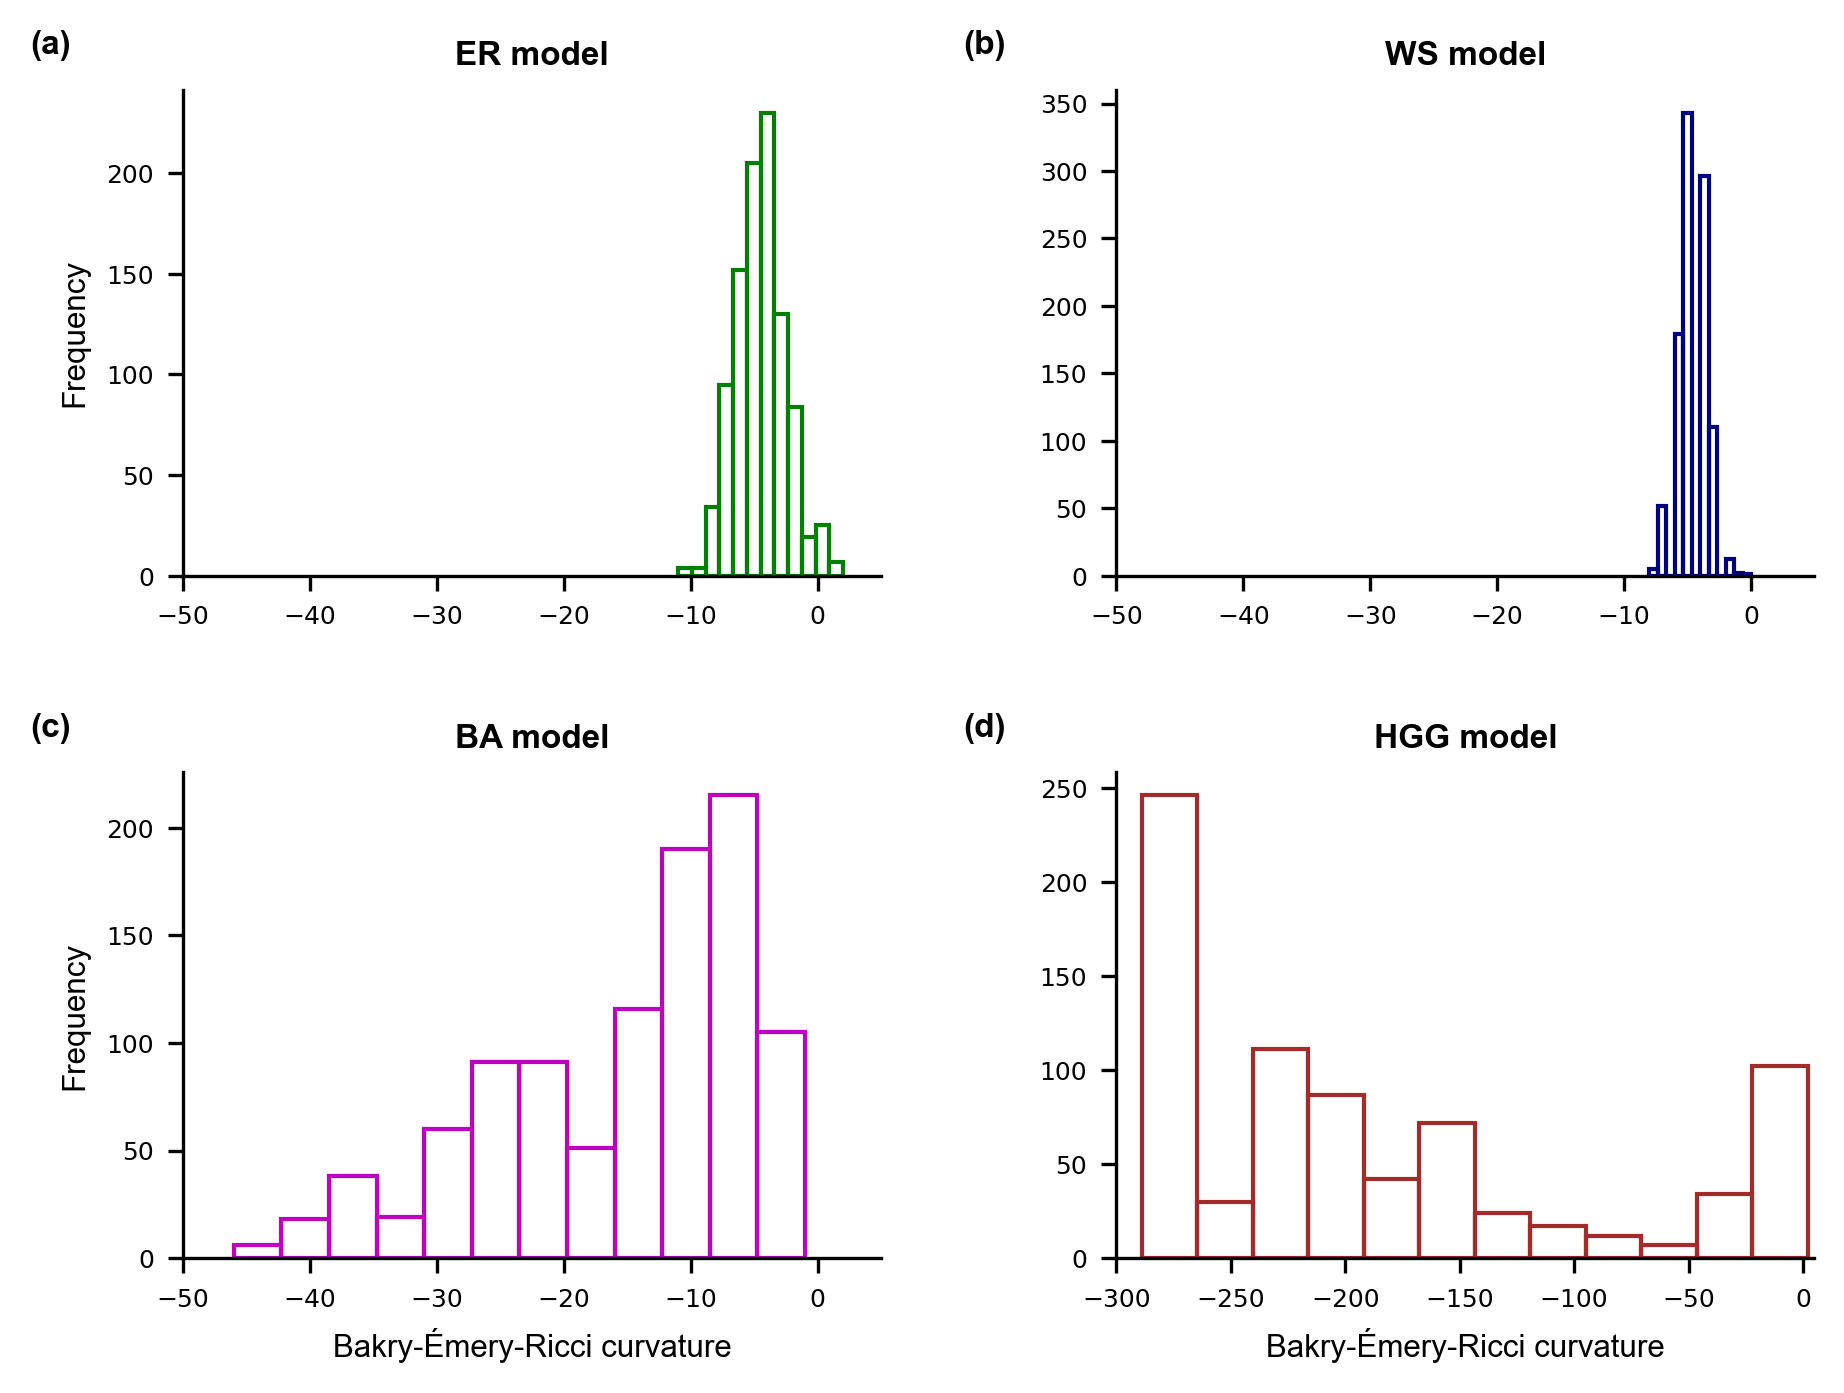

In [5]:
#-------------------------------------------------------------------------------
# Distribution of Bakry-Emery Curvature for four different model networks
#-------------------------------------------------------------------------------

fig, axes = plt.subplots(2, 2, figsize = (6.5,5))

path = '../Data/Model_Networks/'
models = ['ER','WS','BA','HGG']
parameters = ['1000_0.005','1000_6_0.5','1000_3','1000_3']
titles = ['ER model','WS model','BA model','HGG model']
colours = ['g','navy','m','brown']
labels = ['(a)','(b)','(c)','(d)']
        
for i, (ax, model, parameter, title, c, label) in enumerate(zip(axes.flatten(), models, parameters, titles, colours, labels)):
    plot = BarPlot(model,parameter)
    ax.set_title(title, loc = 'center', fontname="Arial", size = 8,weight='bold')
    ax.bar(plot[0],plot[1], width=plot[2], fill = False, edgecolor = c)
    ax.spines[['right', 'top']].set_visible(False) 
    ax.tick_params(axis='both', labelsize=6)
    ax.locator_params(axis='both', nbins=8)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(-0.1, 1.0, label, transform=ax.transAxes + trans,fontsize=8, va='bottom', fontfamily='Arial',weight='bold')
    if i in [0,2]:
        ax.set_ylabel('Frequency', fontname="Arial", size = 7.5)
    if i in [2,3]:
        ax.set_xlabel('Bakry-Émery-Ricci curvature',fontname="Arial", size = 7.5)
    ax.set_xlim(-50, 5)
    if model == 'HGG':
        ax.set_xlim(-300, 5)
        
fig.tight_layout(pad=2.0)
    
plt.savefig(f'../Figures/BEC_Distribution_Model.pdf',dpi = 600)

## Heatmap of correlation between Bakry-Émery-Ricci curvature and other measures

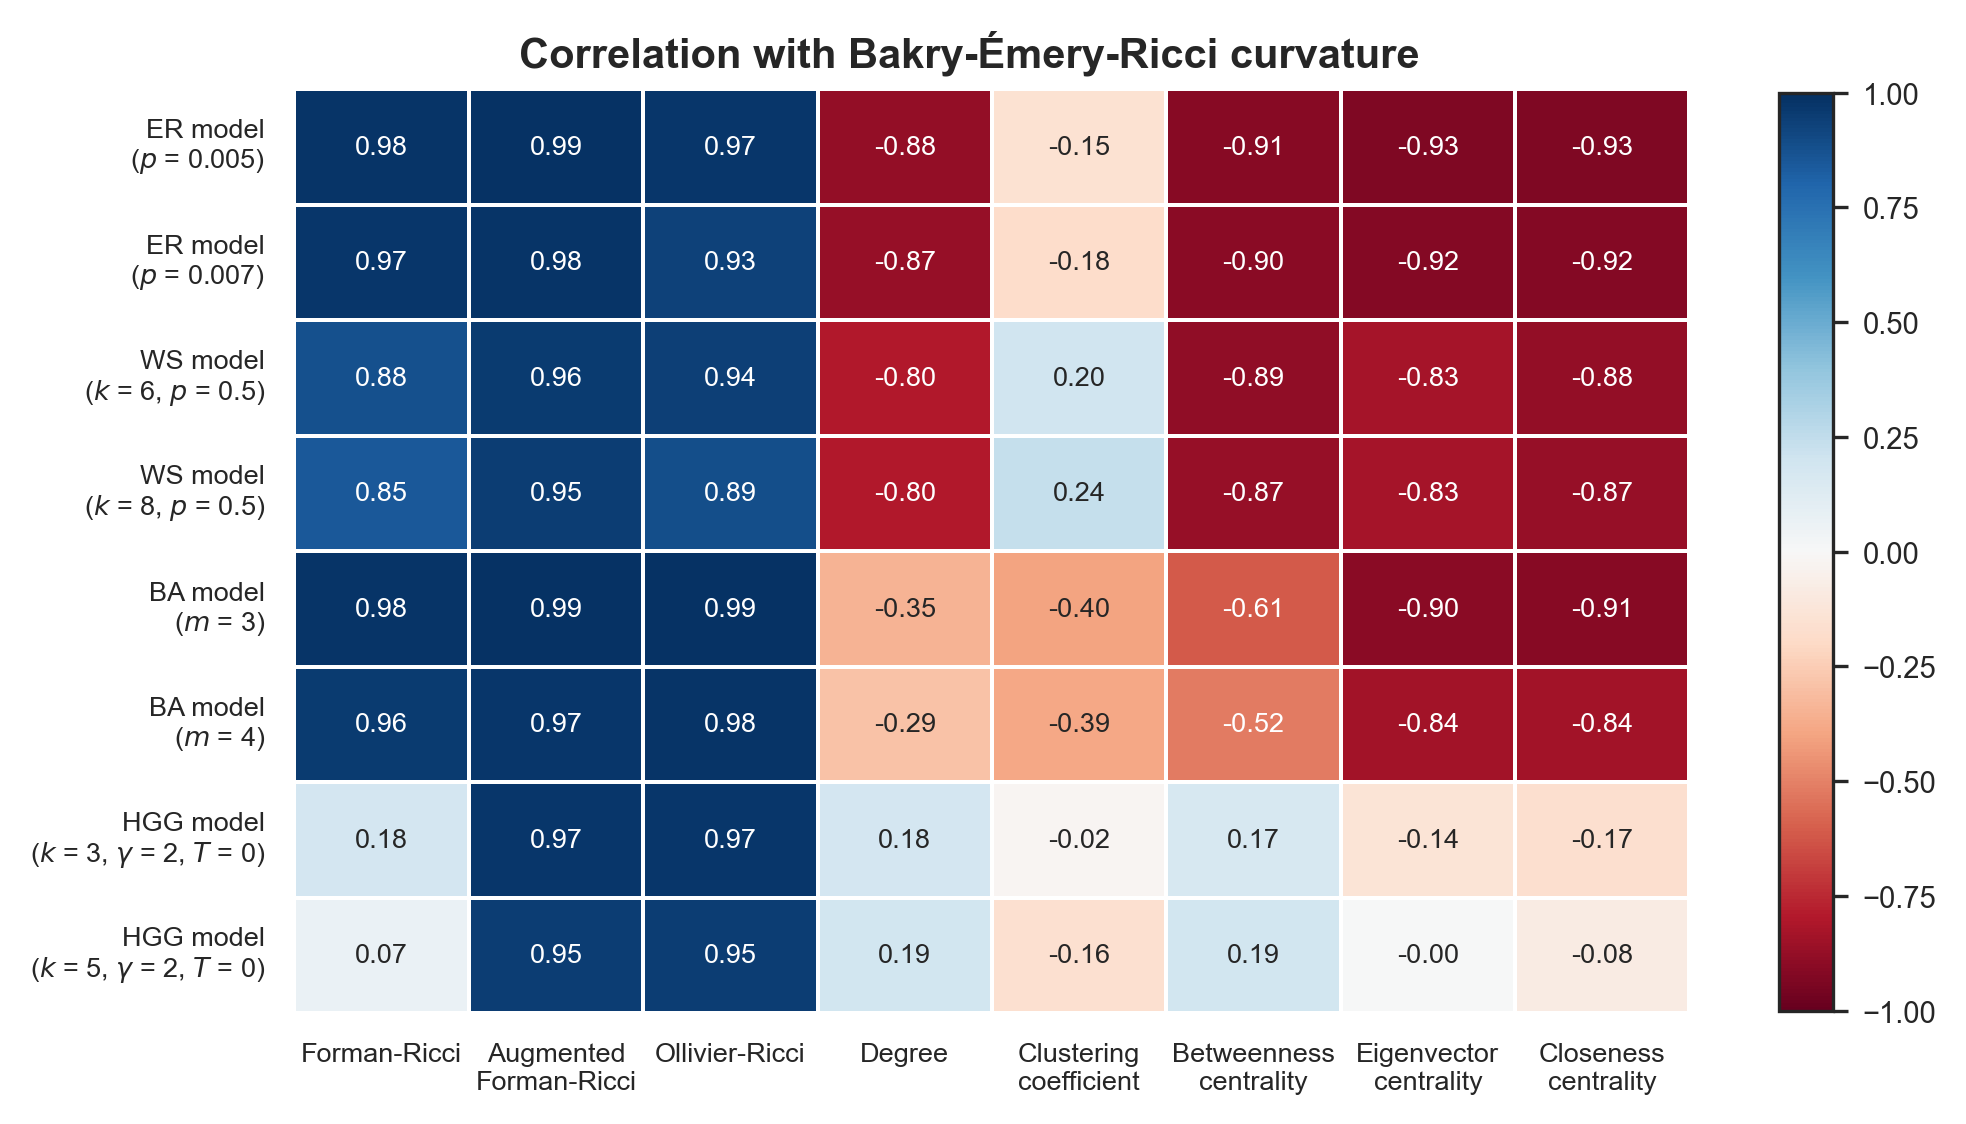

In [19]:
Graph_measure = ['Degree', 'ClusteringCoefficient','BetweennessCentrality','EigenVectorCentrality','ClosenessCentrality']
Curv_measure = ['Forman','AugForman','Ollivier'] 
all_measures = Curv_measure + Graph_measure
models = ['ER','ER','WS','WS','BA','BA','HGG','HGG']
parameters = ['1000_0.005','1000_0.007','1000_6_0.5','1000_8_0.5','1000_3','1000_4','1000_3','1000_5']

df = pd.DataFrame()
for model, parameter in zip( models, parameters):
    path = f'../Data/Model_Networks/{model}/{parameter}/Correlation/'
    p1 = os.listdir(path)
    corrlist = []
    for m2 in all_measures:
        corr = pd.read_csv(path + f'{model}_corr_BakryEmery&{m2}.txt', sep = '\t')
        corrlist.append(round(np.mean(corr['Spearman']),2))
    df[f'{model}_{parameter}']=corrlist
df = df.fillna(0)


fig = plt.figure(figsize = (6,4))
xlabels = ['Forman-Ricci','Augmented\nForman-Ricci','Ollivier-Ricci','Degree','Clustering\ncoefficient',
           'Betweenness\ncentrality','Eigenvector\ncentrality','Closeness\ncentrality']
ylabels = ['ER model\n($\mathit{p}$ = 0.005)','ER model\n($\mathit{p}$ = 0.007)','WS model\n($\mathit{k}$ = 6, $\mathit{p}$ = 0.5)',
           'WS model\n($\mathit{k}$ = 8, $\mathit{p}$ = 0.5)','BA model\n($\mathit{m}$ = 3)','BA model\n($\mathit{m}$ = 4)',
           'HGG model\n($\mathit{k}$ = 3, $\mathit{\gamma}$ = 2, $\mathit{T}$ = 0)', 
           'HGG model\n($\mathit{k}$ = 5, $\mathit{\gamma}$ = 2, $\mathit{T}$ = 0)']

sns.set_style("white")
sns.heatmap(df.T,annot=True, annot_kws={'size':6.5}, fmt='.2f',xticklabels=xlabels, cmap = 'RdBu',
                 yticklabels=ylabels, vmax=1, vmin=-1, linewidth=.5, cbar = False)
plt.xticks(fontsize=6.5, rotation=0)
plt.yticks(fontsize=6.5)
cb_ax = fig.add_axes([0.95, 0.112, 0.03, 0.765])
cmap = sns.color_palette("RdBu", as_cmap=True)
norm = mpt.colors.Normalize(vmin=-1, vmax=1)
cbar = fig.colorbar(mpt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cb_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=7)

plt.suptitle("Correlation with Bakry-Émery-Ricci curvature", fontname="Arial",y=0.93, fontweight='bold', fontsize=10)
plt.savefig(f'../Figures/Correlation_BEC_heatmap_Model.pdf',dpi = 600, bbox_inches='tight')
plt.show()
sns.set_style("ticks")

### Robustness of the model networks under vertices removal

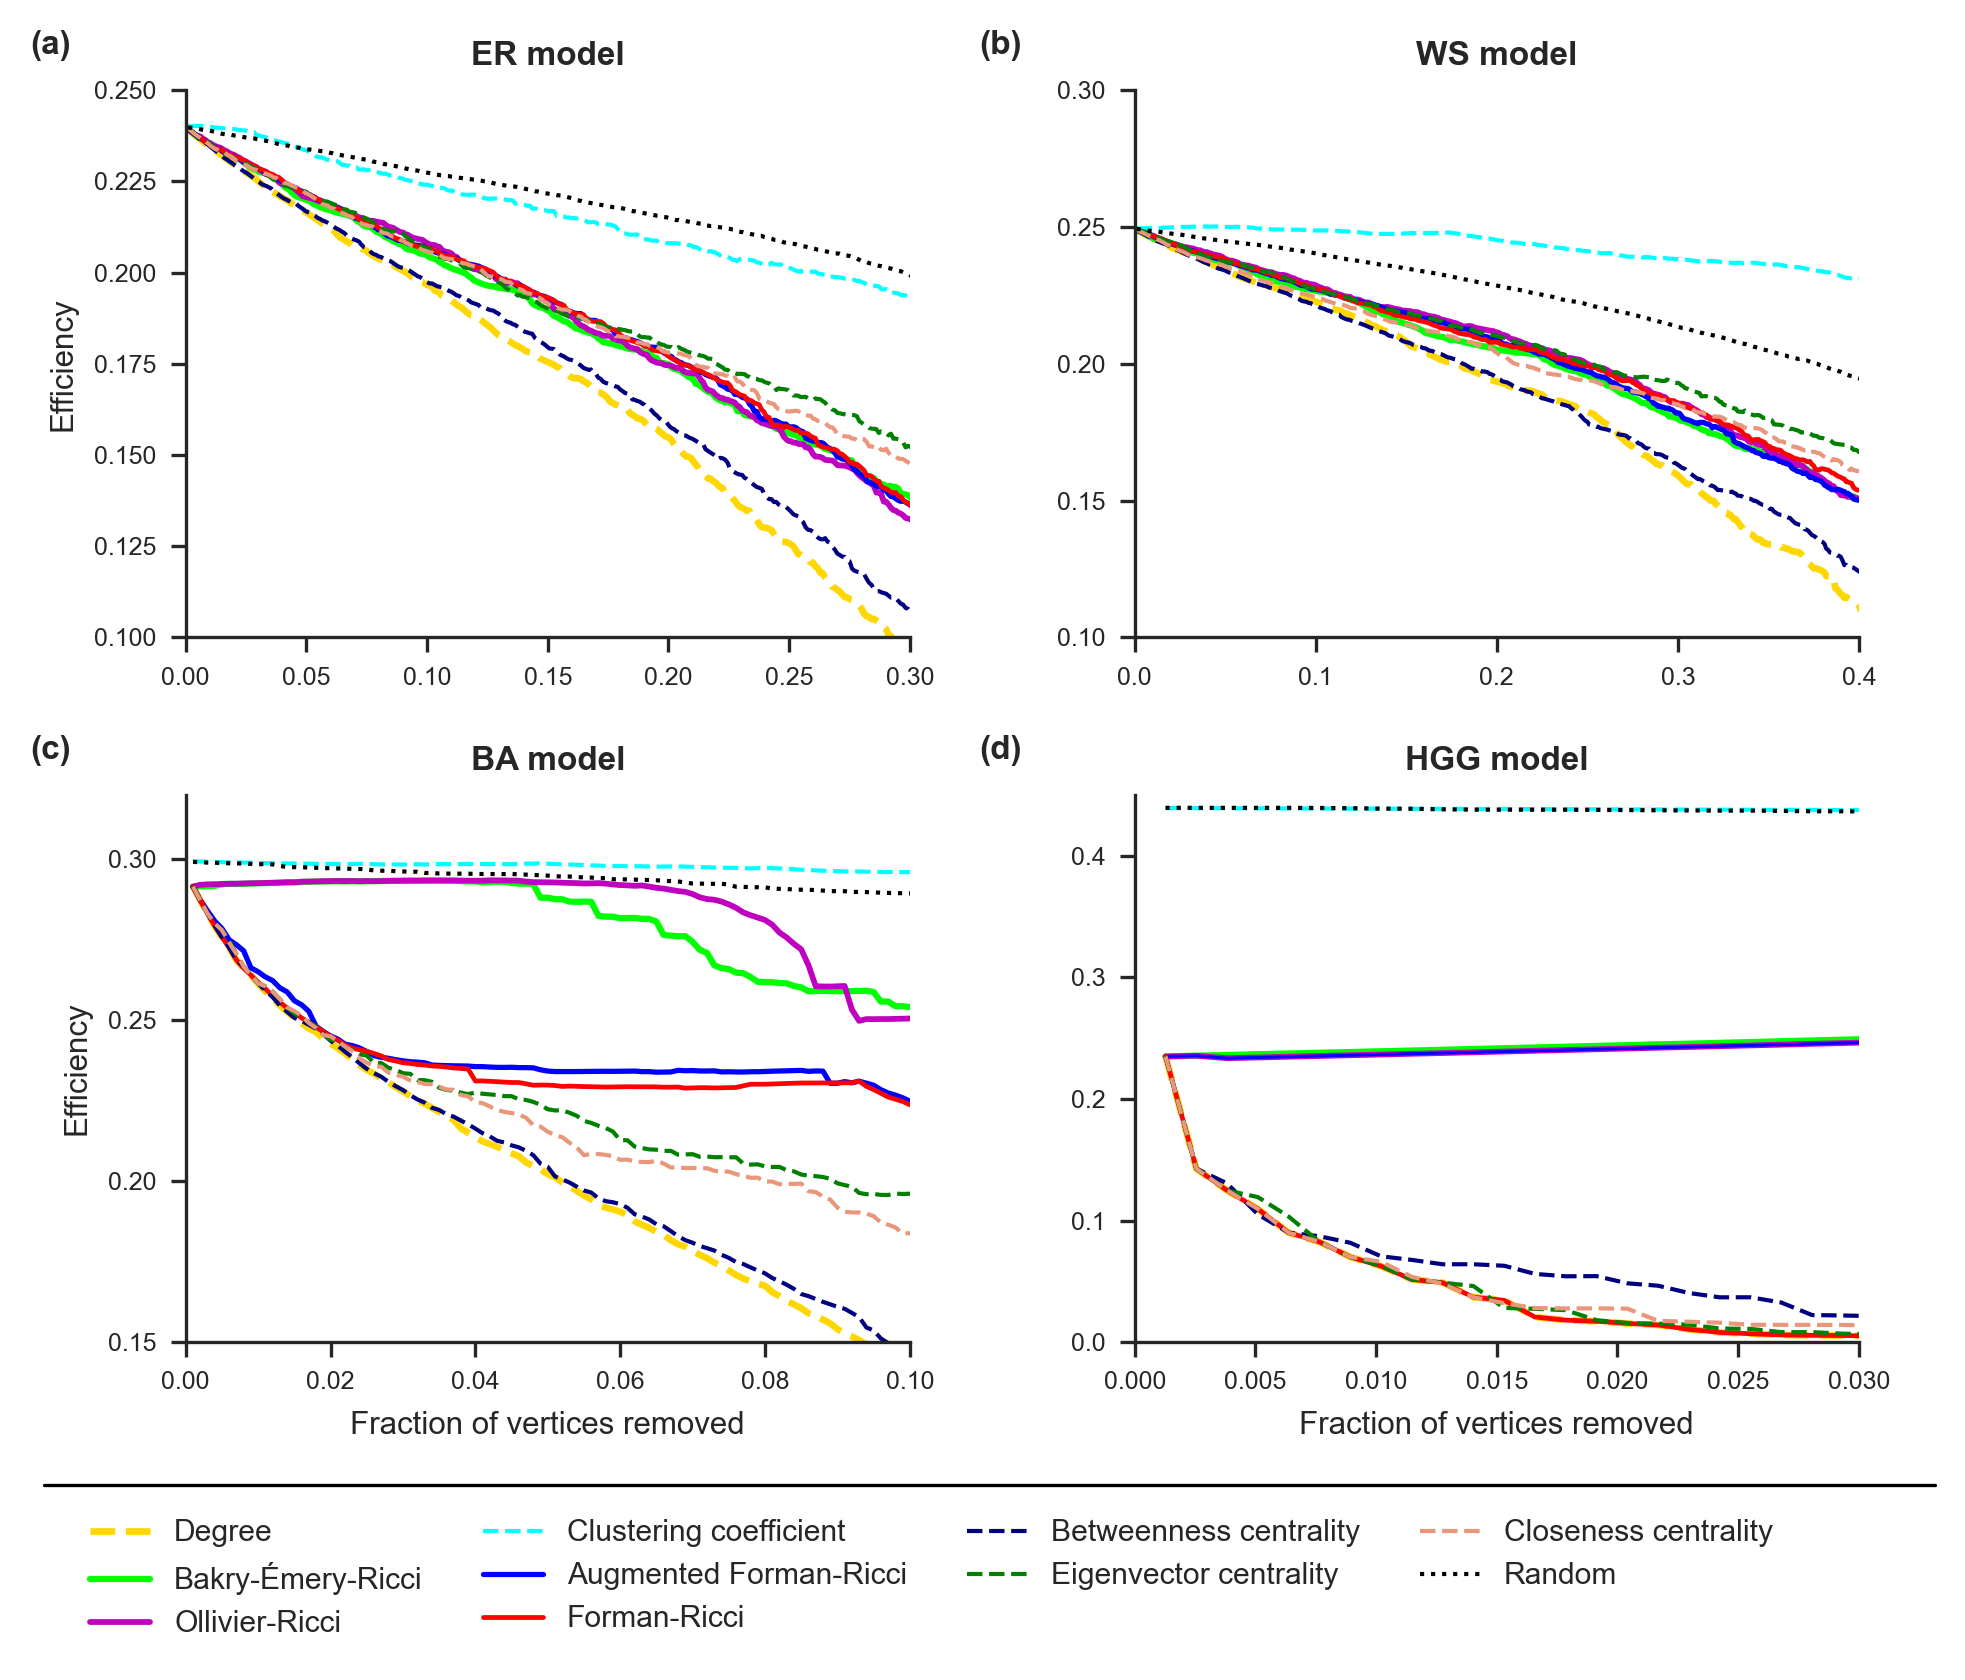

In [7]:
# Define a custom sorting function
def custom_sort(item):
    for m in Orders:
        if m in item:
            return Orders.index(m) 
    return len(Orders)


fig, axes = plt.subplots(2, 2, figsize=(6.5, 5), layout= 'tight')
Orders = ['Degree','BakryEmery','Ollivier','ClusteringCoefficient','AugForman','Forman','BetweennessCentrality',
          'EigenVectorCentrality','ClosenessCentrality','Random']
linestyle = ['--','-','-','--','-','-','--','--','--',':']
models = ['ER','WS','BA','HGG']
dire = ['1000_0.005','1000_6_0.5','1000_3','1000_3']
titles = ['ER model','WS model','BA model','HGG model']
labels = ['(a)','(b)','(c)','(d)']


for i, (ax, model, parameter, title, label) in enumerate(zip(axes.flatten(), models, dire, titles, labels)):
    path = f'../Data/Model_Networks/{model}/{parameter}/Robustness/'
    dire1 = [i for i in os.listdir(path)]
    dire2 = sorted(dire1, key=custom_sort)[:10]
    colours = ['gold','lime','m','cyan','b','r','navy','g','DarkSalmon','black']
    no = 0
    lw = ['1.5,1.4,1.15,1']
    for name,c,ls in zip(dire2, colours, linestyle):
        alpha=1
        file = pd.read_csv(path + name, sep = '\t')
        if 'Degree' in name:
            linewidth = 1.6
        elif ls != '-' :
            linewidth = 1
        else:    
            linewidth = 1.5-(0.12*no)
            no +=1
        if model == 'HGG' and 'AugForman' in name:
            linewidth = 0.7
        ax.plot(file['Fraction_of_nodes'], file['Efficiency'], label = name, color = c, linestyle = ls, linewidth= linewidth)
    ax.set_title(title,loc = 'center', fontname="Arial", size = 8,weight='bold')
    ax.spines[['right', 'top']].set_visible(False) 
    ax.locator_params(axis='both', nbins=6)
    ax.tick_params(axis='both', labelsize=6)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(-0.1, 1.0, label, transform=ax.transAxes + trans,fontsize=8, va='bottom', fontfamily='Arial',weight='bold')
    
axes[0,0].set_xlim(0,0.3)
axes[0,0].set_ylim(0.1,0.25)
axes[0,1].set_xlim(0.0,0.4)
axes[0,1].set_ylim(0.1,0.3)
axes[1,0].set_xlim(0,0.1)
axes[1,0].set_ylim(0.15,0.32)
axes[1,1].set_xlim(0,0.03)
axes[1,1].set_ylim(0,0.45)

axes[1,0].set_xlabel('Fraction of vertices removed',fontfamily='Arial',size = 7.5)
axes[1,1].set_xlabel('Fraction of vertices removed',fontfamily='Arial',size = 7.5)
axes[0,0].set_ylabel('Efficiency',fontfamily='Arial',size = 7.5)
axes[1,0].set_ylabel('Efficiency',fontfamily='Arial',size = 7.5)

n = ('Degree','Bakry-Émery-Ricci','Ollivier-Ricci','Clustering coefficient','Augmented Forman-Ricci','Forman-Ricci',
     'Betweenness centrality','Eigenvector centrality','Closeness centrality','Random')
fig.legend(n,loc="lower left",fontsize = 7.2, bbox_to_anchor=[0.04, -0.12], ncol = 4, edgecolor = 'w') 
line = plt.Line2D([0.03,1],[0,0], lw = 0.8, transform=fig.transFigure, color="black")
fig.add_artist(line)
plt.savefig(f'../Figures/Robustness_Model.pdf', dpi = 600,bbox_inches='tight')
plt.show()

### Robustness of the model networks under vertices removal based on $vertex_{min}$ and $vertex_{sum}$

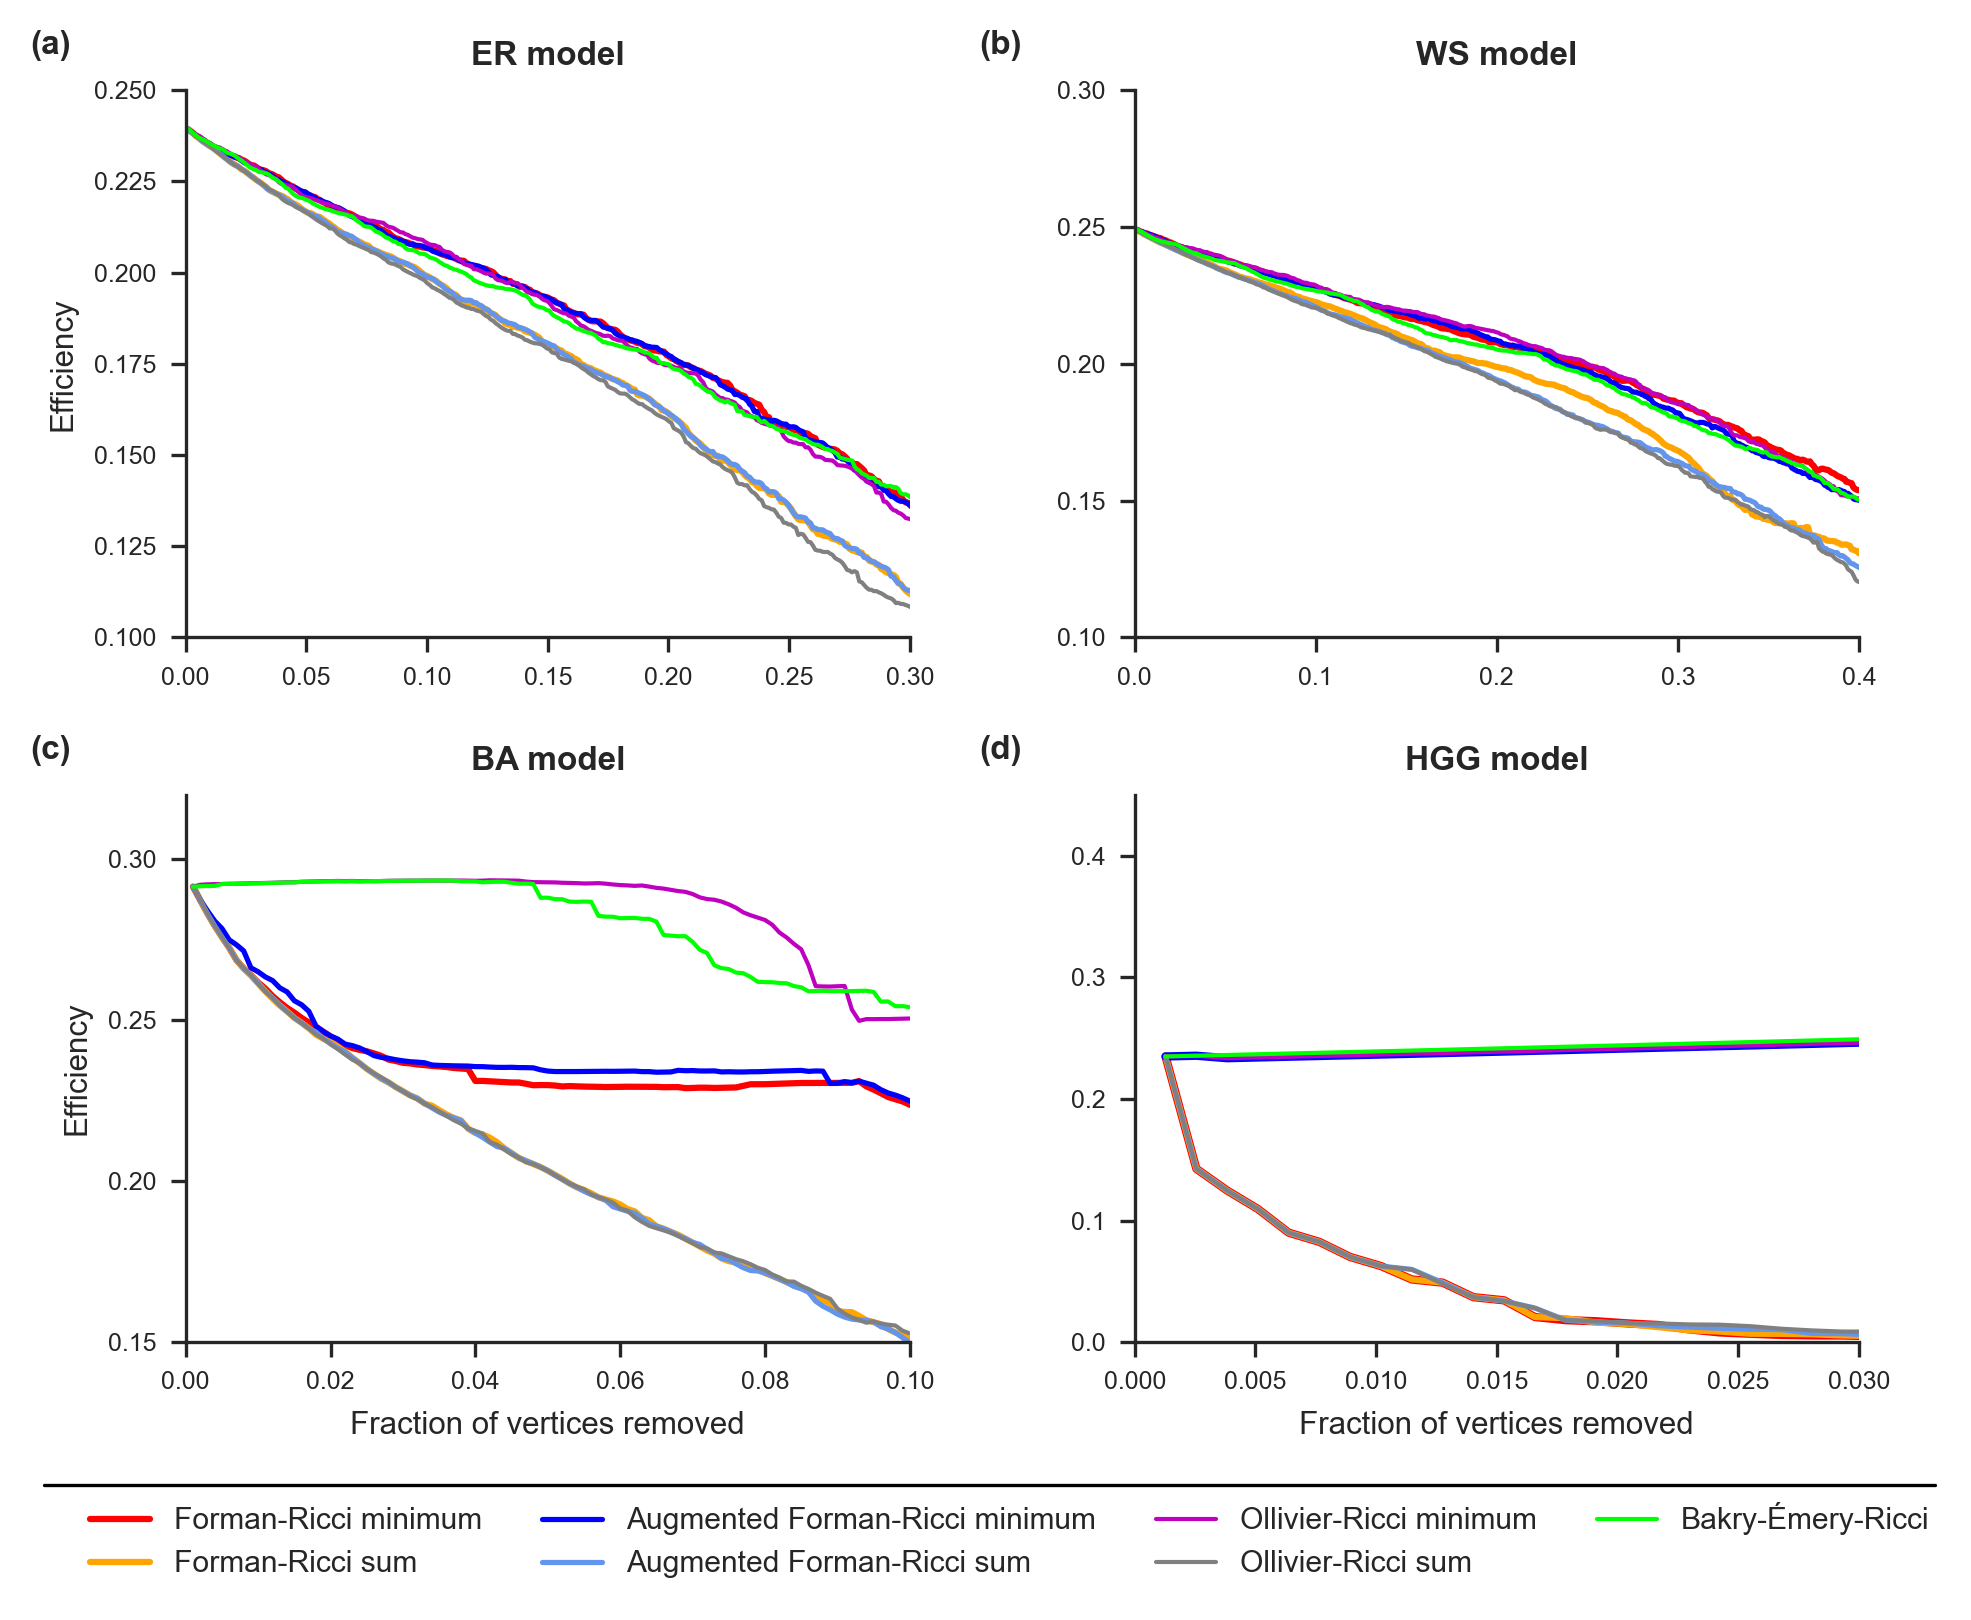

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(6.5, 5), layout= 'tight')

Orders = ['_Forman_min','_Forman_sum','AugForman_min','AugForman_sum','Ollivier_min','Ollivier_sum', 'BakryEmery']
models = ['ER','WS','BA','HGG']
dire = ['1000_0.005','1000_6_0.5','1000_3','1000_3']
titles = ['ER model','WS model','BA model','HGG model']
labels = ['(a)','(b)','(c)','(d)']


for i, (ax, model, parameter, title, label) in enumerate(zip(axes.flatten(), models, dire, titles, labels)):
    path = f'../Data/Model_Networks/{model}/{parameter}/Robustness_curv/'
    dire1 = [i for i in os.listdir(path)]
    dire2 = sorted(dire1, key=custom_sort)
    colours = ['r','orange','b','cornflowerblue','m','gray','lime']
    linewidth = [1.5,1.5,1.25,1.25,1,1,1]
    for name,c,lw in zip(dire2, colours, linewidth):
        alpha=1
        file = pd.read_csv(path + name, sep = '\t')
        if model == 'HGG':
            if 'Forman_min' in name :
                lw = 2
            elif 'AugForman_min' in name:
                lw = 1.3
        ax.plot(file['Fraction_of_nodes'], file['Efficiency'], label = name, linewidth=lw, color = c)
    ax.set_title(title,loc = 'center', fontname="Arial", size = 8,weight='bold')
    ax.spines[['right', 'top']].set_visible(False) 
    ax.locator_params(axis='both', nbins=6)
    ax.tick_params(axis='both', labelsize=6)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(-0.1, 1.0, label, transform=ax.transAxes + trans,fontsize=8, va='bottom', fontfamily='Arial',weight='bold')
    
axes[0,0].set_xlim(0,0.3)
axes[0,0].set_ylim(0.1,0.25)
axes[0,1].set_xlim(0.0,0.4)
axes[0,1].set_ylim(0.1,0.3)
axes[1,0].set_xlim(0,0.1)
axes[1,0].set_ylim(0.15,0.32)
axes[1,1].set_xlim(0,0.03)
axes[1,1].set_ylim(0,0.45)

   
axes[1,0].set_xlabel('Fraction of vertices removed',fontfamily='Arial',size = 7.5)
axes[1,1].set_xlabel('Fraction of vertices removed',fontfamily='Arial',size = 7.5)
axes[0,0].set_ylabel('Efficiency',fontfamily='Arial',size = 7.5)
axes[1,0].set_ylabel('Efficiency',fontfamily='Arial',size = 7.5)

n = ('Forman-Ricci minimum','Forman-Ricci sum','Augmented Forman-Ricci minimum','Augmented Forman-Ricci sum',
     'Ollivier-Ricci minimum','Ollivier-Ricci sum', 'Bakry-Émery-Ricci')
fig.legend(n,loc="lower left",fontsize = 7.2, bbox_to_anchor=[0.04, -0.08], ncol = 4, edgecolor = 'w') 
line = plt.Line2D([0.03,1],[0,0], lw = 0.8, transform=fig.transFigure, color="black")
fig.add_artist(line)

plt.savefig(f'../Figures/Robustness_Model_Curv.pdf', dpi = 600,bbox_inches='tight')
plt.show()